In [427]:
import numpy as np
import pandas as pd
from classifiers import Classifier
from string import punctuation, digits
from tqdm.notebook import tqdm_notebook

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import utils
%matplotlib inline

In [399]:
file_path = './data/Big_AHR.csv'
df = pd.read_csv(file_path, usecols=['rating', 'review_text'])

In [407]:
pd.set_option('max_colwidth', 120)
df.sample(frac=1).head(10)

,rating,review_text
2032,4,Buscábamos mi pareja y yo un hotel intimo y que estuviera cerca de la zona del casco antigüo para poder movernos sin...
5394,5,Un establecimiento agradable con una muy buena relación calidad precio. Limpio discreto y tranquilo. El personal muy...
1721,2,"La habitación tenia hormigas, cosa que no es nada agradable....lo de que te envíen a la calle de detrás, es lo de me..."
17486,1,"Esta habitación era caro para el alojamiento que proporcionaron. La habitación en sí estaba bien, pero la cama era e..."
8238,5,"Todo perfecto, la ubicación genial, puedes ir andando a cualquier sitio y si quieres bus para subir a sacromonte o a..."
2264,2,"La habitación olía a humedad, y mal toalla roida , había pelos de mujer por las sábanas las habitaciones no estan bi..."
12303,5,Bed and Be fue el mejor hostel que quedé en mi viaje por Andalucia. El personal es muy atento y te proporcionan buen...
3644,4,"Buen hotel en primerísima línea de playa, aunque en una urbanización a las afueras de Málaga. Habitaciones muy grand..."
12301,4,Hostel muy bien ubicado. Limpio y con un ambiente super agradable. Muy buena sangria preparan los chicos que toda la...
10327,4,"La ubicación es muy buena, a 15 minutos andando de casi todo lo que hay que ver en Córdoba. Fácil acceso desde la au..."


In [402]:
comments, cols = df.shape
display(Markdown('The file \'{}\' has {:,} comments as rows and {} columns, yes rating and review_text columns.'.format(file_path, comments, cols)))

The file './data/Big_AHR.csv' has 18,172 comments as rows and 2 columns, yes rating and review_text columns.

The beauty of ```np.split```

In [403]:
train_data, validate_data, test_data = np.split(df.sample(frac=1).values,  # random_state=42  # https://www.youtube.com/watch?v=5ZLtcTZP2js&t=83s
                                                [int(.6*len(df)), int(.8*len(df))])

In [408]:
train_data.shape, validate_data.shape, test_data.shape

((10903, 2), (3634, 2), (3635, 2))

We will focus on algorithms, then the we will use [util function](./utils.py) for extract unigram worlds and convert to vector representation.

In [410]:
print(utils.extract_words('Hello my friend'))
print(utils.unigram_words(['this is the first comment', 'this another comment']))

dictionary = utils.unigram_words(train_data[:, 1])
break_point = 3

['hello', 'my', 'friend']
{'this': 0, 'is': 1, 'the': 2, 'first': 3, 'comment': 4, 'another': 5}


In [411]:
X_train.shape, X_validate.shape, X_test.shape


((10903, 27243), (3634, 27243), (3635, 27243))

In [412]:
X_train = utils.extract_unigram_vectors(train_data[:, 1], dictionary)
X_validate = utils.extract_unigram_vectors(validate_data[:, 1], dictionary)
X_test = utils.extract_unigram_vectors(test_data[:, 1], dictionary)

In [413]:
Y_train.shape, Y_validate.shape, Y_test.shape

((10903,), (3634,), (3635,))

In [414]:
Y_train = train_data[:, 0]
Y_validate = validate_data[:, 0]
Y_test = test_data[:, 0]

In [417]:
Y_train

array([1, 1, 1, ..., 1, 1, -1], dtype=object)

In [416]:
for Y in [Y_train, Y_validate, Y_test]:
    Y[Y <= break_point] = -1
    Y[Y > break_point] = 1

In [443]:
class PerceptronClassifier:
    def __init__(self):
        pass

    def __perceptron_one_step(self, x, y, current_theta, current_theta_0) -> (np.ndarray, float):
        if y * (np.dot(current_theta, x) + current_theta_0) <= 0:
            current_theta = current_theta + (y * x)
            current_theta_0 = current_theta_0 + y

        return current_theta, current_theta_0

    def perceptron(self, X, Y, T) -> (np.ndarray, float):
        n, f = X.shape
        theta = np.zeros(f)
        theta_0 = 0
        for t in range(T):
            order = np.arange(n)
            np.random.shuffle(order)
            for i in tqdm_notebook(order, desc = 'Iteration T: {}'.format(t)):
            # for i in self.get_order(n):
                theta, theta_0 = self.__perceptron_one_step(X[i], Y[i], theta, theta_0)

        return theta, theta_0

    def average_perceptron(self, X, Y, T) -> (np.ndarray, float):
        n, f = X.shape
        theta = np.zeros(f)
        theta_s = np.zeros(f)
        theta_0 = 0
        theta_0_s = 0
        for t in range(T):
            order = np.arange(n)
            np.random.shuffle(order)
            for i in tqdm_notebook(order, desc = 'Iteration T: {}'.format(t)):
            # for i in self.get_order(n):
                theta, theta_0 = self.__perceptron_one_step(X[i], Y[i], theta, theta_0)
                theta_s += theta
                theta_0_s += theta_0

        return theta_s / (n * T), theta_0_s / (n * T)

In [442]:
class PegasosClassifier:
    def __init__(self):
        pass

    def __pegasos_one_step(self, x, y, L, eta, current_theta, current_theta_0) -> (np.ndarray, float):
        # current_theta = current_theta + (label * feature_vector)
        # current_theta_0 = current_theta_0 + label
        if y * (np.dot(current_theta, x) + current_theta_0) <= 1:
            current_theta = ((1 - (eta * L)) * current_theta) + (eta * y * x)
            # [optional]
            # current_theta = min(1, (1/np.sqrt(L)) / np.linalg.norm(current_theta)) * current_theta
            current_theta_0 = current_theta_0 + (eta * y)
        else:
            current_theta = (1 - (eta * L)) * current_theta

        return current_theta, current_theta_0

    def pegasos(self, X, Y, T, L) -> (np.ndarray, float):
        n, f = X.shape
        theta = np.zeros(f)
        theta_0 = 0
        counter = 1
        eta = 1 / np.sqrt(counter)
        for t in range(T):
            order = np.arange(n)
            np.random.shuffle(order)
            for i in tqdm_notebook(order, desc = 'Iteration T: {}'.format(t)):
            # for i in self.get_order(n):
                theta, theta_0 = self.__pegasos_one_step(X[i], Y[i], L, eta, theta, theta_0)
                counter += 1
                eta = 1 / np.sqrt(counter)

        return theta, theta_0

In [444]:
class Classifier(PerceptronClassifier, PegasosClassifier):
    def __init__(self, X_train, X_val, Y_train, Y_val, T):
        self.X_train = X_train
        self.X_val = X_val
        self.Y_train = Y_train
        self.Y_val = Y_val
        self.T = T

    def get_order(self, n_samples):
        try:
            with open(str(n_samples) + '.txt') as fp:
                line = fp.readline()
                return list(map(int, line.split(',')))
        except FileNotFoundError:
            random.seed(1)
            indices = list(range(n_samples))
            random.shuffle(indices)
            return indices

    def accuracy(self, preds, targets) -> float:
        """
        Given length-N vectors containing predicted and target labels,
        returns the percentage and number of correct predictions.
        """
        return (preds == targets).mean()

    def classify(self, X, theta, theta_0) -> np.ndarray:
        preds = (np.dot(X, theta.T)) + theta_0
        preds[preds > 0] = 1
        preds[preds <= 0] = -1
        return preds

    def classifier_accuracy(self, classifier, L=None) -> (float, float):
        print("{} -> T: {}, L: {}".format(classifier, self.T, L))
        if self.T and L:
            theta, theta_0 = classifier(self.X_train, self.Y_train, self.T, L)
        elif self.T:
            theta, theta_0 = classifier(self.X_train, self.Y_train, self.T)

        Y_train_predicted = self.classify(self.X_train, theta, theta_0)
        X_val_predicted = self.classify(self.X_val, theta, theta_0)

        accuracy_train = self.accuracy(Y_train_predicted, self.Y_train)
        accuracy_val = self.accuracy(X_val_predicted, self.Y_val)

        return accuracy_train, accuracy_val

    def tune(self, train_fn, param_vals, train_feats, train_labels, val_feats, val_labels):
        train_accs = np.ndarray(len(param_vals))
        val_accs = np.ndarray(len(param_vals))

        for i, val in enumerate(param_vals):
            theta, theta_0 = train_fn(train_feats, train_labels, val)

            train_preds = self.classify(train_feats, theta, theta_0)
            train_accs[i] = self.accuracy(train_preds, train_labels)

            val_preds = self.classify(val_feats, theta, theta_0)
            val_accs[i] = self.accuracy(val_preds, val_labels)

        return train_accs, val_accs

    def tune_perceptron(self, *args):
        return self.tune(self.perceptron, *args)

    def tune_avg_perceptron(self, *args):
        return self.tune(self.average_perceptron, *args)

    def tune_pegasos_T(self, best_L, *args):
        def train_fn(features, labels, T):
            return self.pegasos(features, labels, T, best_L)

        return self.tune(train_fn, *args)

    def tune_pegasos_L(self, best_T, *args):
        def train_fn(features, labels, L):
            return self.pegasos(features, labels, best_T, L)

        return self.tune(train_fn, *args)

    def most_explanatory_word(self, theta, wordlist):
        """Returns the word associated with the bag-of-words feature having largest weight."""
        # theta(i) mientras mas grande es es mas explanatory_word / positive,
        # el indice asociado theta[i], wordlist[i] se mueve en par cuando se hace sort.
        return [word for (theta_i, word) in sorted(zip(theta, wordlist))[::-1]]

In [445]:
T = 10
L = 0.01
clf = Classifier(X_train, X_validate, Y_train, Y_validate, T=T)

In [446]:
pct_train_accuracy, pct_val_accuracy = clf.classifier_accuracy(clf.perceptron)
print("{:35} {:.4f}".format("Training accuracy for perceptron:", pct_train_accuracy))
print("{:35} {:.4f}".format("Validation accuracy for perceptron:", pct_val_accuracy))

avg_pct_train_accuracy, avg_pct_val_accuracy =  clf.classifier_accuracy(clf.average_perceptron)
print("{:43} {:.4f}".format("Training accuracy for average perceptron:", avg_pct_train_accuracy))
print("{:43} {:.4f}".format("Validation accuracy for average perceptron:", avg_pct_val_accuracy))

avg_peg_train_accuracy, avg_peg_val_accuracy =  clf.classifier_accuracy(clf.pegasos, L=L)
print("{:50} {:.4f}".format("Training accuracy for Pegasos:", avg_peg_train_accuracy))
print("{:50} {:.4f}".format("Validation accuracy for Pegasos:", avg_peg_val_accuracy))

<bound method PerceptronClassifier.perceptron of <__main__.Classifier object at 0x0000022E0C99E490>> -> T: 10, L: None


Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Training accuracy for perceptron:   0.9673
Validation accuracy for perceptron: 0.8910
<bound method PerceptronClassifier.average_perceptron of <__main__.Classifier object at 0x0000022E0C99E490>> -> T: 10, L: None


Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Training accuracy for average perceptron:   0.9893
Validation accuracy for average perceptron: 0.9235
<bound method PegasosClassifier.pegasos of <__main__.Classifier object at 0x0000022E0C99E490>> -> T: 10, L: 0.01


Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Training accuracy for Pegasos:                     0.9293
Validation accuracy for Pegasos:                   0.9048


The following lines show how the analisys for chose the best hyperparameters.

In [447]:
data = (X_train, Y_train, X_validate, Y_validate)

# values of T and lambda to try
Ts = [1, 5, 10, 15, 25, 50]
Ls = [0.001, 0.01, 0.1, 1, 10]

pct_tune_results = clf.tune_perceptron(Ts, *data)
print('perceptron valid:', list(zip(Ts, pct_tune_results[1])))
print('best = {:.4f}, T={:.4f}'.format(np.max(pct_tune_results[1]), Ts[np.argmax(pct_tune_results[1])]))

avg_pct_tune_results = clf.tune_avg_perceptron(Ts, *data)
print('avg perceptron valid:', list(zip(Ts, avg_pct_tune_results[1])))
print('best = {:.4f}, T={:.4f}'.format(np.max(avg_pct_tune_results[1]), Ts[np.argmax(avg_pct_tune_results[1])]))

# fix values for L and T while tuning Pegasos T and L, respective
fix_L = 0.01
peg_tune_results_T = clf.tune_pegasos_T(fix_L, Ts, *data)
print('Pegasos valid: tune T', list(zip(Ts, peg_tune_results_T[1])))
print('best = {:.4f}, T={:.4f}'.format(np.max(peg_tune_results_T[1]), Ts[np.argmax(peg_tune_results_T[1])]))

fix_T = Ts[np.argmax(peg_tune_results_T[1])]
peg_tune_results_L = clf.tune_pegasos_L(fix_T, Ls, *data)
print('Pegasos valid: tune L', list(zip(Ls, peg_tune_results_L[1])))
print('best = {:.4f}, L={:.4f}'.format(np.max(peg_tune_results_L[1]), Ls[np.argmax(peg_tune_results_L[1])]))


Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/10903 [00:00<?, ?it/s]

perceptron valid: [(1, 0.860484314804623), (5, 0.8874518436984039), (10, 0.9078150798018713), (15, 0.907264722069345), (25, 0.9116675839295542), (50, 0.9097413318657127)]
best = 0.9117, T=25.0000


Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/10903 [00:00<?, ?it/s]

avg perceptron valid: [(1, 0.907264722069345), (5, 0.9212988442487617), (10, 0.9204733076499725), (15, 0.9218492019812878), (25, 0.9168959823885525), (50, 0.9144193725921849)]
best = 0.9218, T=15.0000


Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/10903 [00:00<?, ?it/s]

Pegasos valid: tune T [(1, 0.8998348926802422), (5, 0.9003852504127683), (10, 0.8987341772151899), (15, 0.8940561364887176), (25, 0.9036873968079252), (50, 0.9058888277380297)]
best = 0.9059, T=50.0000


Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/10903 [00:00<?, ?it/s]

Pegasos valid: tune L [(0.001, 0.9196477710511832), (0.01, 0.9053384700055036), (0.1, 0.8318657127132636), (1, 0.7157402311502477), (10, 0.7157402311502477)]
best = 0.9196, L=0.0010


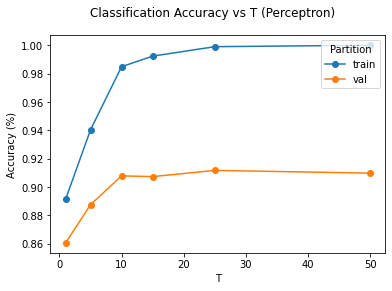

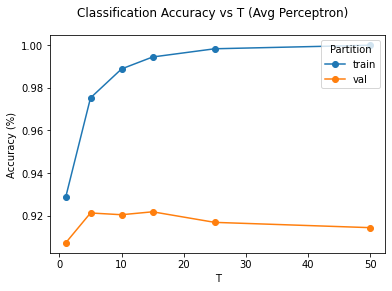

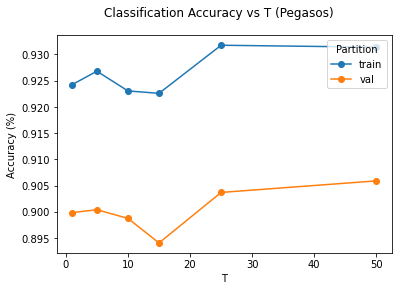

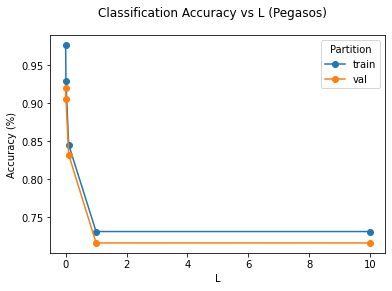

In [449]:
utils.plot_tune_results('Perceptron', 'T', Ts, *pct_tune_results)
utils.plot_tune_results('Avg Perceptron', 'T', Ts, *avg_pct_tune_results)
utils.plot_tune_results('Pegasos', 'T', Ts, *peg_tune_results_T)
utils.plot_tune_results('Pegasos', 'L', Ls, *peg_tune_results_L)

Iteration T: 0:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/10903 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/10903 [00:00<?, ?it/s]

test bow accuracy: 0.9254470426409904
Most Explanatory Word Features
['impecable', 'modernas', 'sorprendió', 'enorme', 'inmejorable', 'genial', 'encantado', 'recién', 'larios', 'diseño']


ValueError: WordCloud has not been calculated, call generate first.

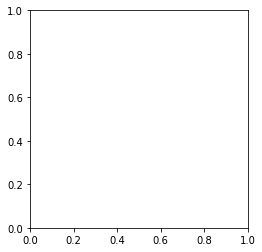

In [453]:
# Hyperparameters
Tp = 15
Lp = 0.01
thetha_t, thetha_t_0 = clf.average_perceptron(X_train, Y_train, Tp)
test_predicted_labels = clf.classify(X_test, thetha_t, thetha_t_0)
test_accuracy = clf.accuracy(test_predicted_labels, Y_test)
print("test bow accuracy: {}".format(test_accuracy))

best_theta = thetha_t
wordlist   = [word for (idx, word) in sorted(zip(dictionary.values(), dictionary.keys()))]
sorted_word_features = clf.most_explanatory_word(best_theta, wordlist)
print("Most Explanatory Word Features")
print(sorted_word_features[:10])



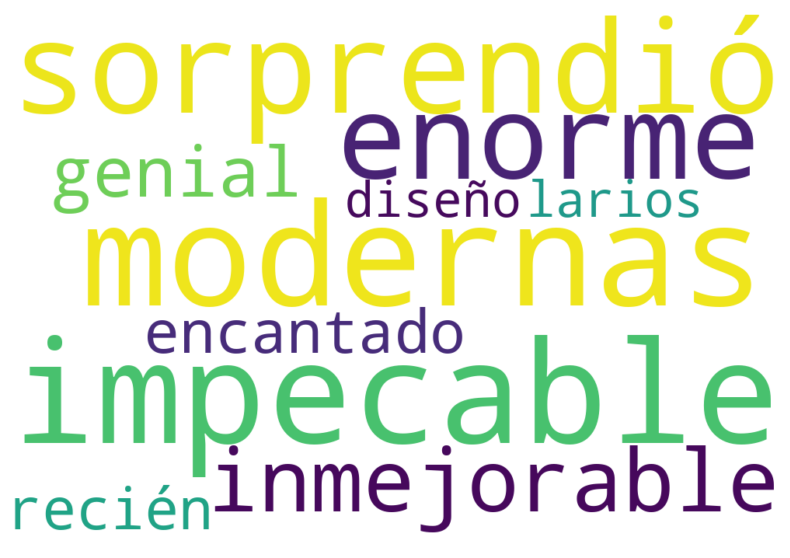

In [461]:
from wordcloud import WordCloud

unique = (" ").join(sorted_word_features[:10])

wordcloud = WordCloud(background_color="white", width=1000, height=700).generate(unique)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()